In [1]:
import pickle

import pandas as pd
import numpy as np
import xarray as xr
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Not sure yet

In [2]:
with open('./data/interim/event_stats_numpy_dict.pickle', 'rb') as handle:
    event_statistics = pickle.load(handle)

In [3]:
# import pandas as pd

### i think this was unnecessary

In [54]:
one_pixel = pd.DataFrame(event_statistics[25, 25]).drop(['time_start', 'time_end', 'time_peak', 
                                                         'index_start', 'index_end', 'index_peak'],
                                                        axis=1)

In [63]:
one_pixel = one_pixel.set_index(pd.to_datetime(one_pixel['date_start']))

In [103]:
monthly_onepix = one_pixel.resample('MS').mean()

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_4170/1588824420.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_onepix = one_pixel.resample('MS').mean()


In [92]:
full_dates = pd.date_range('2002/01/01', '2022-12-01', freq='MS')

In [112]:
monthly_onepix = monthly_onepix.reindex(full_dates)

In [131]:
monthly_onepix

,duration,duration_moderate,duration_strong,duration_severe,duration_extreme,intensity_max,intensity_mean,intensity_var,intensity_cumulative,intensity_max_relThresh,intensity_mean_relThresh,intensity_var_relThresh,intensity_cumulative_relThresh,intensity_max_abs,intensity_mean_abs,intensity_var_abs,intensity_cumulative_abs,rate_onset,rate_decline,n_events
2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,8.5,8.5,0.0,0.0,0.0,2.075113,1.762329,0.175722,15.013152,0.625235,0.299319,0.175402,2.562738,302.019989,301.619080,0.273535,2564.109863,0.206265,0.208475,50.0
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-01,5.0,5.0,0.0,0.0,0.0,2.875186,2.372160,0.381524,11.860801,1.110137,0.621917,0.365718,3.109583,289.910004,289.207977,0.621021,1446.039917,0.639031,0.349931,50.0


#### Average number of MHW per year = about 3.6

In [137]:
annual_count = one_pixel.groupby(one_pixel.index.year).count()

In [150]:
annual_count = annual_count.set_index(pd.to_datetime({'year': annual_count.index, 'month': 1, 'day': 1}))

In [153]:
annual_count = annual_count.reindex(pd.date_range('2002', '2022', freq='YS'))

<AxesSubplot: >

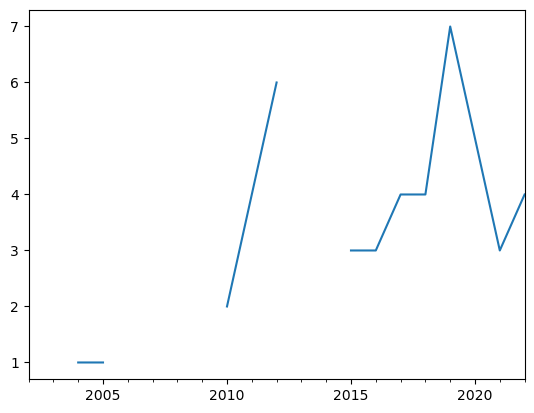

In [159]:
annual_count['duration'].plot()

#### MHW averaged 10 days in length
(in this pixel)

In [132]:
monthly_onepix.duration.mean()

10.05813953488372

<AxesSubplot: >

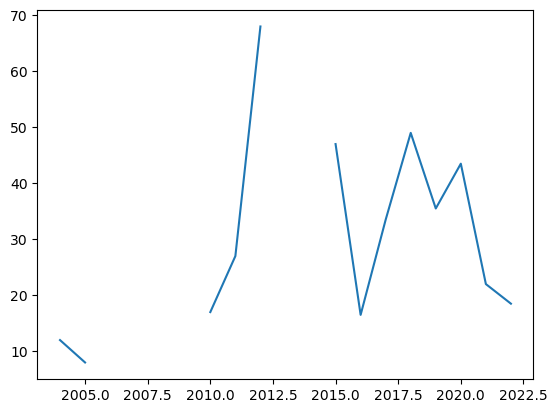

In [130]:
monthly_onepix.duration.groupby(monthly_onepix.index.year).sum().replace({0: None}).plot()

## Making this happen for all the pixels

### Calculating stats for each year

In [3]:
def no_annual_events(time_arr):
    '''
    counts the number of MHW in each year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2023)))
    for i, yr in enumerate(range(2003, 2023)):
        year_counts[i] = np.count_nonzero(years == yr)

    return year_counts

In [4]:
def total_no_mhw_days_yearly(time_arr):
    '''
    counts the number of MHW days in each year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2023)))
    # loop through each of the years we are analyzing
    for i, yr in enumerate(range(2003, 2023)):
        this_year_dur = []
        # go through each mhw in the list and check if the year is the current year
        for sample_year, duration  in zip(years, time_arr['duration']): 
            if sample_year == yr:
                # if the year is part of the current year, extract the value
                this_year_dur = np.append(this_year_dur, duration)
        # sum all the durations for that year and save it in year index i of year_counts
        year_counts[i] = np.sum(this_year_dur)

    return year_counts

In [5]:
def avg_duration_yearly(time_arr):
    '''
    average duration of mhw in each year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2023)))
    # loop through each of the years we are analyzing
    for i, yr in enumerate(range(2003, 2023)):
        this_year_dur = []
        # go through each mhw in the list and check if the year is the current year
        for sample_year, duration  in zip(years, time_arr['duration']): 
            if sample_year == yr:
                # if the year is part of the current year, extract the value
                this_year_dur = np.append(this_year_dur, duration)
        # sum all the durations for that year and save it in year index i of year_counts
        annual_mean = np.mean(this_year_dur)
        if np.isnan(annual_mean):
            annual_mean = 0
        year_counts[i] = annual_mean
        
    return year_counts

In [6]:
avg_duration_yearly(event_statistics[25, 25]).shape

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(20,)

In [7]:
yearly_events = np.vectorize(no_annual_events, signature='()->(n)')(event_statistics)
mhw_days = np.vectorize(total_no_mhw_days_yearly, signature='()->(n)')(event_statistics)
avg_duration = np.vectorize(avg_duration_yearly, signature='()->(n)')(event_statistics)

In [8]:
yearly_events.shape

(65, 40, 20)

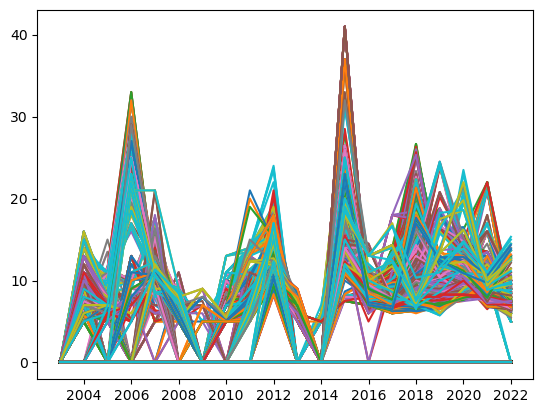

In [9]:
plt.figure()
for i in range(avg_duration.shape[0]):
    for j in range(avg_duration.shape[1]):
        plt.plot(pd.date_range('2002', '2022', freq='Y'), avg_duration[i, j])
plt.show()

## Calculating regression

### Regression Trends

MOVE TO ANALYSIS NOTEBOOK

In [10]:
def linear_regression_wrapper(arr, max_pval):
    """ Calculate the linear regression along 20 years and return just the slope
    of the line, if the p_value is above a threshold value
    """
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20), arr)
    # filter out points that aren't significant
    if p_value > max_pval:
        slope = np.nan

    return slope

In [11]:
yearly_events_slope = np.apply_along_axis(linear_regression_wrapper, 2, yearly_events, 0.05)
mhw_days_slope = np.apply_along_axis(linear_regression_wrapper, 2, mhw_days, 0.05)
avg_duration_slope = np.apply_along_axis(linear_regression_wrapper, 2, avg_duration, 0.05)

In [16]:
yearly_events_slope_da = xr.DataArray(yearly_events_slope,coords=[avg_mean_intensity.latitude.values, avg_mean_intensity.longitude.values], 
             dims=['latitude', 'longitude'])
mhw_days_slope_da = xr.DataArray(mhw_days_slope,coords=[avg_mean_intensity.latitude.values, avg_mean_intensity.longitude.values], 
             dims=['latitude', 'longitude'])
avg_duration_slope_da = xr.DataArray(avg_duration_slope,coords=[avg_mean_intensity.latitude.values, avg_mean_intensity.longitude.values], 
             dims=['latitude', 'longitude'])

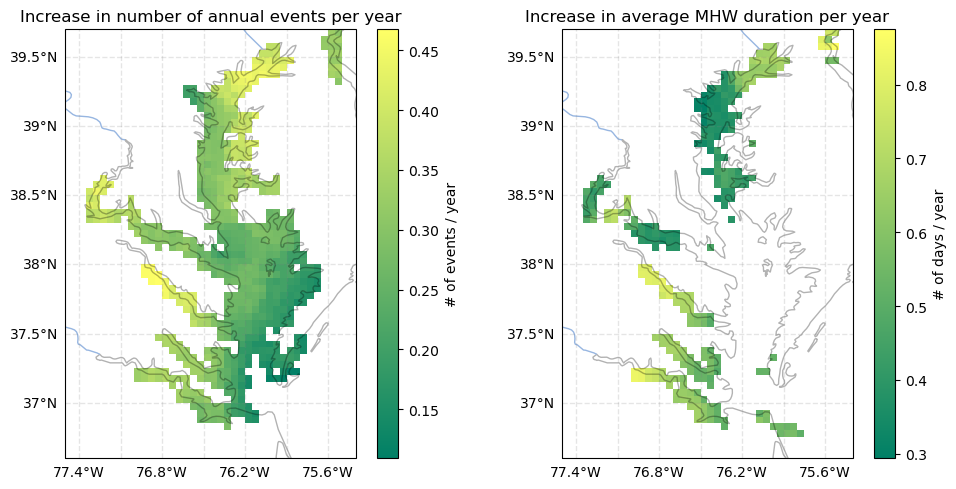

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False


yearly_events_slope_da.plot(ax=axes[0], cmap='summer', cbar_kwargs={'label': '# of events / year'})
axes[0].set_title('Increase in number of annual events per year')

avg_duration_slope_da.plot(ax=axes[1], cmap='summer', cbar_kwargs={'label': '# of days / year'})
axes[1].set_title('Increase in average MHW duration per year')

# mhw_days_slope_da.plot(ax=axes[2], cmap='summer', cbar_kwargs={'label': '# of days / year'})
# axes[2].set_title('Change in mhw days / year')

plt.tight_layout()

plt.savefig('figures/mhw_longterm_trends.png')

### Plot over Time

Averaging (not summing) over all the pixels)

In [18]:
mhw_days_annual_mean = mhw_days.mean(axis=0).mean(axis=0)

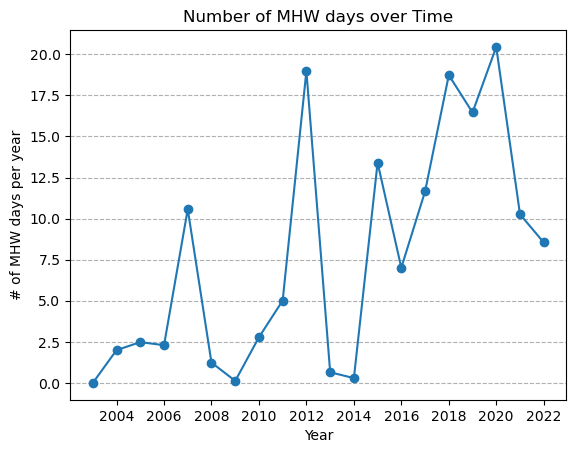

In [19]:
plt.plot(pd.date_range('2003', '2022', freq='YS'), mhw_days_annual_mean, marker='o')
plt.xlabel('Year')
plt.ylabel('# of MHW days per year')
plt.title('Number of MHW days over Time')

plt.grid(axis='y', linestyle='--')
# plt.ylim([0, 22])

plt.savefig('figures/mhw_days_timeseries.png')

# Full Bay MHW days

MOVE TO ANALYSIS NOTEBOOK

Mazzini -- 2 MWH / year, 11 day avg duration, 22 MHW days / year

In [20]:
avg_no_annual_events = xr.open_dataset('data/processed/mhw_stats_outputs/average_no_annual_events_CBay_geopolar.nc').avg_no_annual_events
avg_mean_intensity = xr.open_dataset('data/processed/mhw_stats_outputs/average_mean_intensity_CBay_geopolar.nc').avg_mean_intensity
avg_duration = xr.open_dataset('data/processed/mhw_stats_outputs/average_mhw_duration_CBay_geopolar.nc').avg_duration


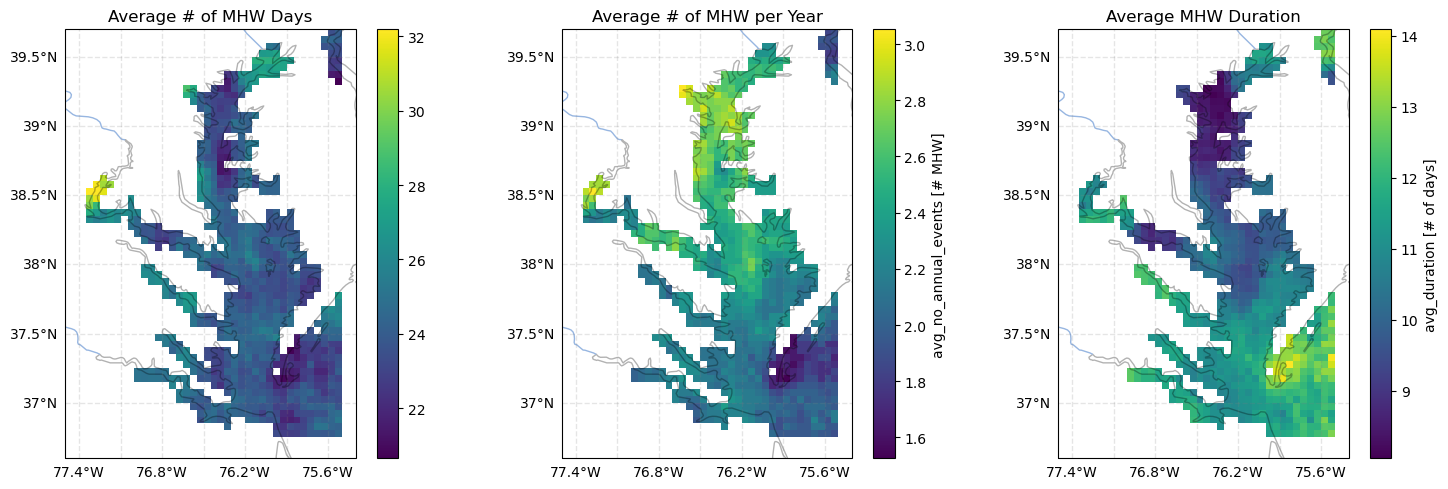

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

(avg_no_annual_events * avg_duration).plot(ax=axes[0])
axes[0].set_title('Average # of MHW Days')
avg_no_annual_events.plot(ax=axes[1])
axes[1].set_title('Average # of MHW per Year')
avg_duration.plot(ax=axes[2])
axes[2].set_title('Average MHW Duration')


plt.tight_layout()
plt.savefig('./figures/averge_mhw_days.png')

### Because that duration thing really bothers me

A cute little thing I just did but I don't think it took my anywhere

In [22]:
# 0, 39 is the bottom right corner
avg_duration.isel(latitude=0, longitude=39).values
# event_statistics[0, 39]

array(12.89189189)

In [ ]:
# UPPER BAY POINT
avg_duration.isel(latitude=47, longitude=23).values

In [ ]:
# LOWER BAY POINT
avg_duration.isel(latitude=15, longitude=27).values

In [ ]:
event_statistics.shape

In [ ]:
upper_starts = event_statistics[45, 25]['date_start']
upper_ends = event_statistics[45, 25]['date_end']
lower_starts = event_statistics[15, 25]['date_start']
lower_ends = event_statistics[15, 25]['date_end']

In [ ]:
plt.figure(figsize=(30,5))

# upper will be at y = 1, lower will be at y = 2
x1, y1 = [upper_starts[0], upper_ends[0]], [1]*2
x2, y2 = [lower_starts[0], lower_ends[0]], [1.2]*2
plt.plot(x1, y1, x2, y2, marker='o')

In [ ]:
plt.figure(figsize=(60,1))

# upper will be at y = 1.2, lower will be at y = 1
for i in range(len(upper_starts)):
    x1, y1 = [upper_starts[i], upper_ends[i]], [1.2]*2
    plt.plot(x1, y1, marker='o')

for i in range(len(lower_starts)):
    x1, y1 = [lower_starts[i], lower_ends[i]], [1]*2
    plt.plot(x1, y1, marker='o')

plt.savefig('./scratch.png')

In [13]:
all_days = pd.date_range('2002-01-01', '2022-12-31')
events_upper = pd.DataFrame({'MHW': len(upper_starts)*[1]}, index=pd.to_datetime(upper_starts)).reindex(all_days)
events_lower = pd.DataFrame({'MHW': len(upper_starts)*[1]}, index=pd.to_datetime(upper_starts)).reindex(all_days)

NameError: name 'upper_starts' is not defined

In [14]:
events_upper

NameError: name 'events_upper' is not defined

# Looking at start date

In [58]:
len(event_statistics[25, 25]['date_start'])

50

In [59]:
def monthly_start_dates(time_arr):
    starts = pd.DataFrame({'date_start': pd.to_datetime(time_arr['date_start'])})
    monthly = starts.groupby(starts['date_start'].dt.month).count()['date_start']
    # Reindex to a full 12 months, in case there are missing months 
    # (land values have all missing months)
    monthly = monthly.reindex(range(1, 13))
    return monthly.values

In [60]:
monthly_start_dates(event_statistics[0,0]).shape

(12,)

In [61]:
# total # of pixels
print('max ', event_statistics.size)

max  2600


In [62]:
# The number of mhw that started in that month, time series plotted for all the pixels
plt.figure()
for i in range(monthly_starts.shape[0]):
    for j in range(monthly_starts.shape[1]):
        plt.plot(range(1, 13), monthly_starts[i, j])
plt.show()

NameError: name 'monthly_starts' is not defined

<Figure size 640x480 with 0 Axes>

In [63]:
# The number of mhw that started in that month, time series plotted for all the pixels
plt.figure()
for i in range(monthly_starts.shape[0]):
    for j in range(monthly_starts.shape[1]):
        plt.scatter(range(1, 13), monthly_starts[i, j], color='blue', alpha=0.02)
plt.show()

NameError: name 'monthly_starts' is not defined

<Figure size 640x480 with 0 Axes>

In [64]:
time_arr = event_statistics[25, 25]

In [65]:
time_df = pd.DataFrame({'date_start': pd.to_datetime(time_arr['date_start'])})

In [66]:
months = time_df.groupby([pd.cut(time_df['date_start'].dt.year, [2002, 2007, 2012, 2017, 2022]), time_df['date_start'].dt.month]).count()


In [67]:
hacking = months.swaplevel(0, 1).sort_index(1)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_47294/2838377727.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  hacking = months.swaplevel(0, 1).sort_index(1)


<AxesSubplot: xlabel='date_start,date_start'>

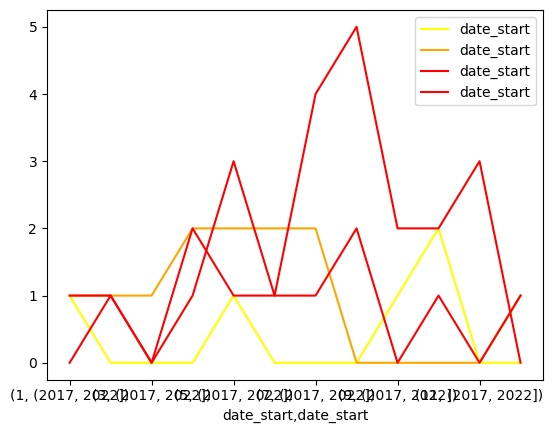

In [68]:
fig, ax = plt.subplots()

hacking.iloc[:12].plot(color='yellow', ax=ax)
hacking.iloc[12:24].plot(color='orange', ax=ax)
hacking.iloc[24:36].plot(color='red', ax=ax)
hacking.iloc[36:48].plot(color='red', ax=ax)